# Pet + Supermarket Training sample on Mac GPU


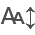

In [30]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import mysql.connector
import pandas as pd
import numpy as np
import requests
from collections import Counter
import re
import unidecode
import matplotlib.pyplot as plt
import seaborn as sns
import time

import glob
from ast import literal_eval

import io
import math

import warnings
warnings.filterwarnings("ignore")

from numpy.linalg import norm
from matplotlib import colors

import pickle
from dotenv import load_dotenv
import json


from vertexai.preview.language_models import TextEmbeddingModel

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

from transformers import BertTokenizer, TFBertModel
from transformers import AdamW, AdamWeightDecay, WarmUp
#import tensorflow_text as text

import warnings
warnings.filterwarnings("ignore")

from itables import init_notebook_mode
init_notebook_mode(all_interactive=True)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,f1_score,classification_report

## functions

In [73]:
##preprocessing
#dict units
dict_units = {}
dict_units['u'] = ['u', 'un', 'und' 'unit', 'units', 'unidad', 'unidades']
dict_units['cm'] = ['cm', 'cms', 'centimeter', 'centimetros']
dict_units['l'] = ['l', 'lt', 'lts', 'litro', 'litros', 'litre', 'litres']
dict_units['m'] = ['m', 'mt', 'mts', 'metro', 'metros', 'meter', 'meters']
dict_units['gr'] = ['g', 'gr', 'grs', 'gramo', 'gramos', 'gram', 'grams']
dict_units['ml'] = ['ml', 'mls', 'mililitro', 'mililitros', 'millilitre', 'millilitres']
dict_units['kg'] = ['kg', 'kgs', 'kilo', 'k', 'kilos', 'kilogramo', 'kilogramos', 'kilogram', 'kilograms']
dict_units['lb'] = ['lb','lbs', 'libra', 'libras']
dict_units['cc'] = ['cc', 'ccs']
dict_units['mm'] = ['mm', 'mms', 'milimetro', 'milimetros', 'millimeter', 'millimeters']
dict_units['mg'] = ['mg', 'mgs', 'miligramo', 'miligramos', 'milligram', 'milligrams']
dict_units['gb'] = ['gb', 'gigabyte', 'gigabytes']
dict_units['kb'] = ['kb', 'kilobyte', 'kilobytes']
dict_units['mb'] = ['mb', 'megabyte', 'megabytes']
dict_units['tb'] = ['tb', 'terabyte', 'terabytes']
dict_units['w'] = ['w', 'watts']
dict_units['hz'] = ['hz', 'hertz']
dict_units['oz'] = ['oz', 'onza', 'onzas', 'ounce']

def get_key(val, dict):
    """returns the key of the dict_units dict"""
    for key, value in dict.items():
        if val in value:
            return key

def split_float(text, dict_units):
    '''split skus quantity with unit, ex: 20grs, 20 grs'''
    for key, values in dict_units.items():
        pattern = '|'.join(values)
        #split skus quantity with unit, ex:
        text = re.sub(r'(\d+\.?\d*)(' + pattern + r')', r'\1 \2', text)
    return text

def split_combos(text):
    '''split skus with promotions: ex: '6x100gr' , '6 x 100gr' '''
    text = re.sub(r'(\d+)x(\d+)', r'\1 x \2', text)
    return text

def remove_integer_pattern(text):
    # Define the regex pattern to match 4 or 5 integers followed by a space and another 4 or 5 integers
    pattern = r'\b\d{4,5} \d{4,5}\b'
    
    result = re.sub(pattern, '', text)
    # Remove any extra spaces left after removing the pattern
    result = re.sub(r'\s{2,}', ' ', result).strip()
    
    return result

##AGREGADO ESPECIAL, ESPECIALES ---> para categorias
def join_units(string, dict_units=dict_units):
    """joins numbers with following units (ej:250 grs = 250gr)"""

    # stopwords and dict for merging units to numbers in titles
    stop_words = ['and', 'for', 'the', 'with', 'to', 'y', 'de', 'que', 'en', 'para', 'del', 'le', 'les', 'lo', 'los',
                  'la', 'las', 'con', 'que', 'gratis', 'promo', 'promocion', 'promotion', 'oferta', 'ofertas', 'free', 'gratis',
                  'descuento', 'descuentos', 'dcto', 'pagina', 'page', 'null', 'price', 'precio', 'precios', 'producto',
                  'productos', 'product', 'products', 'combo', 'ceba'] #'especial', 'especiales', 'special', 'specials'

    dict_values = np.hstack(list(dict_units.values()))

    string_f_split = [token for token in string.split() if token not in stop_words]

    aux = []
    block_next = -1
    for index in range(len(string_f_split)):

        if index == block_next:  # skip word
            continue

        try:
            float_num = float(string_f_split[index])
            next_val = string_f_split[index + 1]
            try:
                next_float_num = float(next_val)
                if next_float_num:
                    val = string_f_split[index]
                    aux.append(val)
                    continue

            except:
                if index != len(string_f_split) and \
                        bool(re.search(r'\d', string_f_split[index + 1])) == False and \
                        string_f_split[index + 1] in dict_values:

                    val = str(float_num).rstrip('0').rstrip('.') + get_key(string_f_split[index + 1], dict_units)
                    aux.append(val)
                    block_next = index + 1
                    continue

                else:
                    val = string_f_split[index]
                    aux.append(val)
                    continue

        except:
            val = string_f_split[index]
            aux.append(val)
            continue

    formatted = ' '.join(aux)
    return formatted



def preprocess_products(row, dict_units=dict_units):
    """preprocess the product based on rules"""
    row = row.lower()
    row = row.replace('unknown','').replace(',','.') .replace('&nbsp', ' ').replace('\xa0','').replace('"','').replace('solo delivery','').\
          replace('cyber monday','')
    #for pets
    row = row.replace("/", ' ').replace('**entrega en 2 dias habiles**','').replace('**entrega en 4 dias habiles**','').replace('**entrega en 6 dias habiles**','').\
          replace('**entrega en 7 dias habiles**','').replace('** entrega en 2 dias habiles**','').replace('** entrega en 4 dias habiles**','').\
          replace('** entrega en 6 dias habiles**','').replace('** entrega en 7 dias habiles**','').replace(' ** entrega en 4 dias habiles **','').\
          replace('gabrica sas','').replace('gabrica medicamentos','').replace('gabrica alimentos','').replace('jaramillo pets cia sca','').replace('synergylabs','').replace('verosa group sas','').\
          replace('select pets colombia sas','').replace('italcol occidente sa','').replace('solo delivery','').replace('colombia sas','').replace('colombia sa','').\
          replace('virbac colombia ltda','').replace('concentrados norte 1 sas','').replace('gesto agro sas','').replace('industria colombiana farmaceutica icofar','').\
          replace('flatazor','').replace('alimentos italcol','').replace('comercial mas bios s a','').replace('colombia ltda','')
    
    row = ''.join(re.findall('[-+]?(?:\d*\.\d+|\d+)|\d|\s|\w|\+', row)) #.lower()
    row = row.replace('-', ' ')
    row = re.sub(r'[_]', ' ', row)
    aux = ['mas' if token == '+' else token for token in row.split()]
    row = ' '.join(aux)

    row = unidecode.unidecode(row)  # removes special characters
    row = split_combos(row)
    row = split_float(row, dict_units)
    row = remove_integer_pattern(row)
    row = join_units(row)  # units formatting
    row = row.split()
    row = " ".join(sorted(set(row), key=row.index))  # removes duplicates

    return row

## Loading MAC GPU

In [3]:
#Cargando GPU de mac

# Set TensorFlow to use the Metal PluggableDevice
n = 8
tf.config.experimental.set_virtual_device_configuration(
    tf.config.experimental.list_physical_devices('GPU')[0],
    [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=n*1024)])

print("TensorFlow version:", tf.__version__)
print("Num GPUs Available:", len(tf.config.experimental.list_physical_devices('GPU')))

TensorFlow version: 2.13.0
Num GPUs Available: 1


In [5]:
from tensorflow.python.client import device_lib

def get_available_gpus():
    """returns the available gpus for the API"""
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']


In [6]:
get_available_gpus()

['/device:GPU:0']

In [27]:
if tf.config.list_physical_devices('GPU'):
  strategy = tf.distribute.MirroredStrategy()
  print('Using GPU')
else:
  raise ValueError('Running on CPU is not recommended.')

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Using GPU


## Bert Model & tokenizer

In [7]:
#BERT multi

bert_multi = 'bert-base-multilingual-uncased'
#Loading tokenizer
tokenizer= BertTokenizer.from_pretrained(bert_multi)

MAX_LENGTH = 35

In [8]:
def join_products(product_1, product_2):
  join = [f'{p1} [SEP] {p2}' for p1,p2 in zip(product_1,product_2)]
  return join

## Data

In [9]:
ds_train = pd.read_csv('ds_train_hybrid_11-06-24.csv', index_col=0)
ds_eval = pd.read_csv('ds_eval_hybrid_11-06-24.csv', index_col=0)
ds_test = pd.read_csv('ds_test_hybrid_11-06-24.csv', index_col=0)

In [10]:
#sample
ds_train_sample = ds_train.sample(frac=0.1)
ds_eval_sample = ds_eval.sample(frac=0.1)
ds_test_sample = ds_eval.sample(frac=0.1)

In [18]:
len(ds_train_sample), len(ds_eval_sample), len(ds_test_sample) 

(15658, 1799, 1799)

In [14]:
#train
product_1 = ds_train_sample.brand_and_product.tolist()
product_2 = ds_train_sample.brand_and_product_candidate.tolist()

join_products_training = join_products(product_1, product_2)
target_training = ds_train_sample.target.tolist()


In [16]:
#X_train encoder

X_train_encoded = tokenizer.batch_encode_plus(
    batch_text_or_text_pairs=join_products_training,  # the batch to be encoded
    add_special_tokens=True,  # Add [CLS] and [SEP]
    max_length = MAX_LENGTH,
    pad_to_max_length=True,  # Add [PAD]s
    return_attention_mask = True,
    return_tensors = 'tf',  # tf tensors
)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [19]:
#evaluate
product_1 = ds_eval_sample.brand_and_product.tolist()
product_2 = ds_eval_sample.brand_and_product_candidate.tolist()
target_evaluating = ds_eval_sample.target.tolist()

join_products_evaluating = join_products(product_1, product_2)



In [20]:
#X_eval encoder

X_eval_encoded = tokenizer.batch_encode_plus(
    batch_text_or_text_pairs=join_products_evaluating,  # the batch to be encoded
    add_special_tokens=True,  # Add [CLS] and [SEP]
    max_length = MAX_LENGTH,
    pad_to_max_length=True,  # Add [PAD]s
    return_attention_mask = True,
    return_tensors = 'tf',  # tf tensors
)

In [21]:
#testing
product_1 = ds_test_sample.brand_and_product.tolist()
product_2 = ds_test_sample.brand_and_product_candidate.tolist()
target_testing = ds_test_sample.target.tolist()

join_products_testing = join_products(product_1, product_2)



In [22]:
#X_test encoder

X_test_encoded = tokenizer.batch_encode_plus(
    batch_text_or_text_pairs=join_products_testing,  # the batch to be encoded
    add_special_tokens=True,  # Add [CLS] and [SEP]
    max_length = MAX_LENGTH,
    pad_to_max_length=True,  # Add [PAD]s
    return_attention_mask = True,
    return_tensors = 'tf',  # tf tensors
)

In [23]:
#array to np.array para las dimensiones -> shape: (n,)
y_train = np.array(target_training)
y_test = np.array(target_testing)
y_valid = np.array(target_evaluating)

In [25]:
#X_test_encoded

## Model Architecture

In [26]:
#model architecture

def model_v1(model, seq_length=MAX_LENGTH):

    input_ids = tf.keras.layers.Input(shape=(seq_length,), dtype=tf.int64, name="input_ids")
    attention_mask = tf.keras.layers.Input(shape=(seq_length,), dtype=tf.int64, name="attention_mask")

    embedding_layer = model(input_ids=input_ids, attention_mask=attention_mask)[0]

    max_pool_txt = tf.keras.layers.GlobalMaxPool1D(name = 'max_pooling_txt')(embedding_layer)
    avg_pool_txt = tf.keras.layers.GlobalAveragePooling1D(name = 'avg_pooling_txt')(embedding_layer)
    concat_txt = tf.keras.layers.concatenate([max_pool_txt, avg_pool_txt])

    batch_norm_1_txt = tf.keras.layers.BatchNormalization(name='batch_norm1_txt')(concat_txt)
    dense_1_txt = tf.keras.layers.Dense(256, activation='relu', name='dense_1_txt')(batch_norm_1_txt)
    batch_norm_2_txt = tf.keras.layers.BatchNormalization(name='batch_norm2_txt')(dense_1_txt)
    dropout_1_txt = tf.keras.layers.Dropout(0.25, name='dropout_1_txt')(batch_norm_2_txt) #changed from 0.4 to 0.25

    #fully connected layer
    dense_fc = tf.keras.layers.Dense(128, activation='relu', name='dense_fc')(dropout_1_txt)
    batch_norm_fc = tf.keras.layers.BatchNormalization(name='batch_norm_fc')(dense_fc)
    dropout_fc = tf.keras.layers.Dropout(0.3, name='dropout_fc')(batch_norm_fc)

    output = tf.keras.layers.Dense(1, activation='sigmoid', name='labels')(dropout_fc) #sigmoid instead of softmax, classes=1 :{0..1}

    classif_model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=output)

    return classif_model

In [34]:
NUM_EPOCHS = 10
BATCH_SIZE = 32

with strategy.scope(): # creating the model in the TPU strategy scope
    bert_multi_model = TFBertModel.from_pretrained(bert_multi)
    model_txt_1_adamw = model_v1(bert_multi_model, seq_length=MAX_LENGTH)

    filepath1 = 'hybrid_model_txt_v1_adamw_loss_sample.h5'
    filepath2 = 'hybrid_model_txt_v1_adamw_acc_sample.h5'

    #chekpoints
    checkpoint1 = ModelCheckpoint(filepath1, monitor='val_loss', verbose=1, \
                                  save_best_only=True, save_weights_only=True, \
                                  mode='auto', save_frequency=1)

    checkpoint2 = ModelCheckpoint(filepath2, monitor='val_accuracy', verbose=1, \
                                  save_best_only=True, save_weights_only=True, \
                                  mode='auto', save_frequency=1)

    #early_stop = EarlyStopping(monitor='val_loss', patience=15)
    train_data_size = len(y_train)
    steps_per_epoch = int(train_data_size / BATCH_SIZE)
    num_train_steps = steps_per_epoch * NUM_EPOCHS
    warmup_steps = int(0.1 * num_train_steps)
    lr = 2e-6

    # decay schedule
    linear_decay = tf.keras.optimizers.schedules.PolynomialDecay(
        initial_learning_rate=lr,
        decay_steps=num_train_steps,
        end_learning_rate=0.0)

    # warm-up schedule
    learning_rate_fn = WarmUp(
        initial_learning_rate=lr,
        decay_schedule_fn=linear_decay,
        warmup_steps=warmup_steps
    )

    optimizer = tf.keras.optimizers.experimental.Adam(learning_rate=learning_rate_fn)


    #compile model
    model_txt_1_adamw.compile(loss = 'binary_crossentropy', optimizer= optimizer,
                        metrics=["accuracy",
                                 tf.keras.metrics.AUC(),
                                 tf.keras.metrics.Precision(),
                                 tf.keras.metrics.Recall()])

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [35]:
for index,layer in enumerate(model_txt_1_adamw.layers):

  if index < 3: #freeze bert layer (dont want to tune the bert weights)
    layer.trainable = False


  print(index, layer, layer.trainable)

0 <keras.src.engine.input_layer.InputLayer object at 0x2e81965d0> False
1 <keras.src.engine.input_layer.InputLayer object at 0x2e81f3c90> False
2 <transformers.models.bert.modeling_tf_bert.TFBertModel object at 0x3243fe8d0> False
3 <keras.src.layers.pooling.global_max_pooling1d.GlobalMaxPooling1D object at 0x36fe46e10> True
4 <keras.src.layers.pooling.global_average_pooling1d.GlobalAveragePooling1D object at 0x2e8166cd0> True
5 <keras.src.layers.merging.concatenate.Concatenate object at 0x3245c3090> True
6 <keras.src.layers.normalization.batch_normalization.BatchNormalization object at 0x3245b3210> True
7 <keras.src.layers.core.dense.Dense object at 0x4f7f2edd0> True
8 <keras.src.layers.normalization.batch_normalization.BatchNormalization object at 0x2e81e6250> True
9 <keras.src.layers.regularization.dropout.Dropout object at 0x2e8145510> True
10 <keras.src.layers.core.dense.Dense object at 0x2e8137b90> True
11 <keras.src.layers.normalization.batch_normalization.BatchNormalization obje

In [36]:
start = time.time()


history_1 = model_txt_1_adamw.fit([X_train_encoded['input_ids'], X_train_encoded['attention_mask']], y_train,
                                  validation_data=([X_eval_encoded['input_ids'], X_eval_encoded['attention_mask']], y_valid),
                                  epochs=NUM_EPOCHS, callbacks=[checkpoint1, checkpoint2])

end = time.time()
total_time = end-start
print(f'time taken to train model ({NUM_EPOCHS} epochs): {total_time} secs')

Epoch 1/10


490/490 [==============================] - ETA: 0s - loss: 0.7561 - accuracy: 0.6344 - auc_1: 0.6908 - precision_1: 0.6098 - recall_1: 0.6402
Epoch 1: val_loss improved from inf to 0.43487, saving model to hybrid_model_txt_v1_adamw_loss_sample.h5

Epoch 1: val_accuracy improved from -inf to 0.80434, saving model to hybrid_model_txt_v1_adamw_acc_sample.h5
490/490 [==============================] - 192s 361ms/step - loss: 0.7561 - accuracy: 0.6344 - auc_1: 0.6908 - precision_1: 0.6098 - recall_1: 0.6402 - val_loss: 0.4349 - val_accuracy: 0.8043 - val_auc_1: 0.9406 - val_precision_1: 0.7197 - val_recall_1: 0.9588
Epoch 2/10
490/490 [==============================] - ETA: 0s - loss: 0.3822 - accuracy: 0.8366 - auc_1: 0.9167 - precision_1: 0.8206 - recall_1: 0.8397
Epoch 2: val_loss improved from 0.43487 to 0.27550, saving model to hybrid_model_txt_v1_adamw_loss_sample.h5

Epoch 2: val_accuracy improved from 0.80434 to 0.88827, saving model to hybrid_model_txt_v1_adamw_acc_sample.h5
490/490

In [38]:
model_txt_1_adamw.evaluate([X_test_encoded['input_ids'], X_test_encoded['attention_mask']], y_test)

57/57 [==============================] - 7s 116ms/step - loss: 0.1598 - accuracy: 0.9405 - auc_1: 0.9861 - precision_1: 0.9166 - recall_1: 0.9610


[0.15983512997627258,
 0.9405224919319153,
 0.9861486554145813,
 0.9165726900100708,
 0.9609929323196411]

In [40]:
def model_predict(model, X_test_id,X_test_mask, y_test):

    predicted_y = model.predict([ X_test_id, X_test_mask])
    #print(model.predict_proba(X_test))
    print(classification_report(y_test , predicted_y > 0.5,zero_division=0))

In [41]:
model_predict(model_txt_1_adamw, X_test_encoded['input_ids'], X_test_encoded['attention_mask'], y_test)

57/57 [==============================] - 21s 281ms/step
              precision    recall  f1-score   support

           0       0.96      0.92      0.94       953
           1       0.92      0.96      0.94       846

    accuracy                           0.94      1799
   macro avg       0.94      0.94      0.94      1799
weighted avg       0.94      0.94      0.94      1799



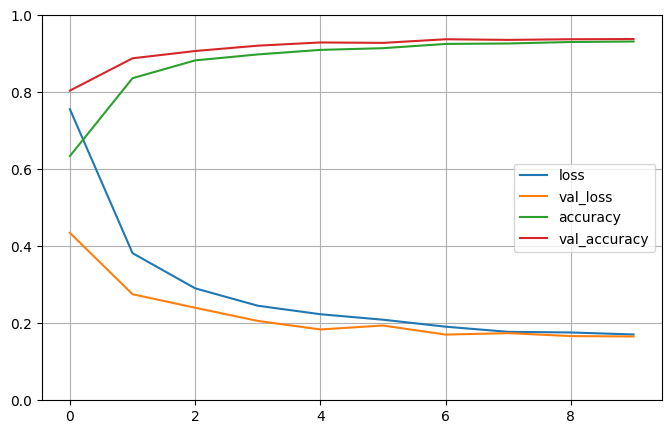

In [42]:

loss_and_acc = {}
loss_and_acc['loss'] = history_1.history['loss']
loss_and_acc['val_loss'] = history_1.history['val_loss']
loss_and_acc['accuracy'] = history_1.history['accuracy']
loss_and_acc['val_accuracy'] = history_1.history['val_accuracy']

df_metrics_1 = pd.DataFrame(loss_and_acc)
df_metrics_1.plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

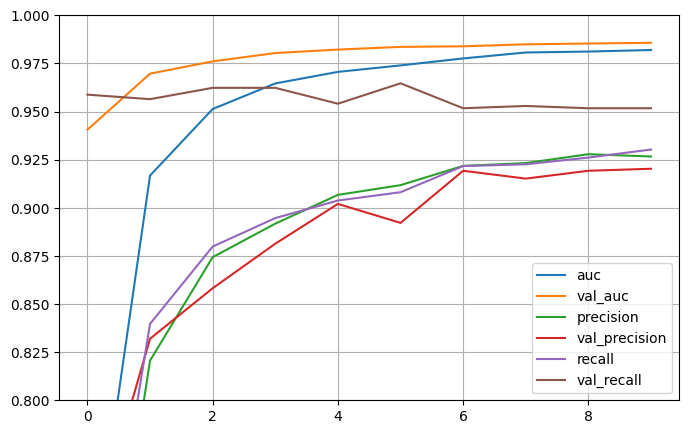

In [49]:

precision_recall = {}
precision_recall['auc'] = history_1.history['auc_1']
precision_recall['val_auc'] = history_1.history['val_auc_1']
precision_recall['precision'] = history_1.history['precision_1']
precision_recall['val_precision'] = history_1.history['val_precision_1']
precision_recall['recall'] = history_1.history['recall_1']
precision_recall['val_recall'] = history_1.history['val_recall_1']

df_metrics_2 = pd.DataFrame(precision_recall)
df_metrics_2.plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0.8,1)
plt.show()

In [54]:
## testing ALL test set

#evaluate
product_1 = ds_test.brand_and_product.tolist()
product_2 = ds_test.brand_and_product_candidate.tolist()
target_testing_all = ds_test.target.tolist()

join_products_testing_all = join_products(product_1, product_2)


In [56]:
y_test_all = np.array(target_testing_all)

In [55]:
#X_test encoder

X_test_all_encoded = tokenizer.batch_encode_plus(
    batch_text_or_text_pairs=join_products_testing_all,  # the batch to be encoded
    add_special_tokens=True,  # Add [CLS] and [SEP]
    max_length = MAX_LENGTH,
    pad_to_max_length=True,  # Add [PAD]s
    return_attention_mask = True,
    return_tensors = 'tf',  # tf tensors
)

In [57]:
model_txt_1_adamw.evaluate([X_test_all_encoded['input_ids'], X_test_all_encoded['attention_mask']], y_test_all)

282/282 [==============================] - 31s 108ms/step - loss: 0.1499 - accuracy: 0.9455 - auc_1: 0.9869 - precision_1: 0.9303 - recall_1: 0.9556


[0.14986814558506012,
 0.9455050230026245,
 0.9868836402893066,
 0.9303287863731384,
 0.9555975198745728]

## mini testing

In [89]:
mini_test = pd.read_csv('pets_supermarket_mini_test_3.csv')

In [90]:
mini_test['b_and_p_1'] = mini_test['brand_and_product'].apply(preprocess_products)
mini_test['b_and_p_2'] = mini_test['brand_and_product_candidate'].apply(preprocess_products)

In [91]:
mini_test

brand_and_product  \
0        OVEN-BAKED TRADITION ADULT CAT- FISH 4,55 Kg   
1    Diamond Natunals Para Perro Small Breed De 15 Kg   
2            MAXPET JAULA TRANSPORTE PERROS MAXPET-06   
3   Pro Plan Reduced Calorie Optifit Canino Razas ...   
4   Collar ruffwear para perros knot amarillo l (5...   
5     Nutrafin Max Tortuga Pellet con Gammarus-65 g\n   
6        Bravery Pork Adult alimento para perro 12 KG   
7                 Acana duck and pear dog treat 35.5g   
8   Royal Canin Alimento Seco Perro Adulto Hypoall...   
9              FRONTLINE SPRAY ANTIPARASITARIO 100 ml   
10              Lysoform Aerosol Desinfectante 495 ml   
11           6x Cerveza Italiana Peroni Lager - 330cc   
12                Costa Chocolate Rolls Nuts 150 Gr\n   
13        Nestum Cereal Infantil Avena Y Arroz, 250 g   
14         Shampoo Granada Uva Bio 750 ml. – Familand   
15  Banquete Aceite de Oliva Banquete Extra Virgen...   
16                         Papa Stax Original 134 Grs   
17                              Heinz ketchup (397 g)   
18               Yerba Mate Rosamonte Clásica 500 grs   
19      OVEN-BAKED TRADITION ADULT CAT- FISH 14,20 Kg   
20   Diamond Natunals Para Perro Small Breed De 15 Kg   
21           MAXPET JAULA TRANSPORTE PERROS MAXPET-06   
22  Calorie Optifit Felino Razas Medianas Con Optifit   
23   Collar  para perros knot amarillo l (51 - 66 cm)   
24    Nutrafin Max Tortuga Pellet con Gammarus-65 g\n   
25       Bravery Pork Adult alimento para perro 12 KG   
26                 Acana lamb and pear dog treat 7 gr   
27  Royal Canin Alimento Seco Perro Adulto Hypoall...   
28             FRONTLINE SPRAY ANTIPARASITARIO 100 ml   
29              Lysoform Aerosol Desinfectante 495 ml   
30          Cerveza Italiana Peroni Lager - 550cc x1    
31                Costa Chocolate Rolls Nuts 150 Gr\n   
32                         Nestum Avena Y Arroz, 3 kg   
33         Shampoo Granada Uva Bio 750 ml. – Familand   
34  Banquete Aceite de Oliva Banquete Extra Virgen...   
35                         Papa Stax Original 134 Grs   
36                              Heinz ketchup (397 g)   
37                       Yerba Mate Playadito 500 grs   
38            OVEN-BAKED TRADITION ADULT dog 14,20 Kg   
39            Diamond Natunals gato Small Breed 15 Kg   
40           MAXPET JAULA TRANSPORTE PERROS MAXPET-06   
41                      Calorie Felino Razas Medianas   
42        Collar  para perros amarillo l (51 - 66 cm)   
43    Nutrafin Max Tortuga Pellet con Gammarus-65 g\n   
44             Bravery Adult alimento para perro 2 KG   
45                          Acana lamb dog treat 7 gr   
46        Royal Canin Alimento Seco Perro puppy 22 KG   
47                       SPRAY ANTIPARASITARIO 100 ml   
48                      Lysoform Desinfectante 495 ml   
49                Cerveza budwaiser Lager - 550cc x1    
50                Costa Chocolate Rolls Nuts 150 Gr\n   
51                         Nestum Avena Y Arroz, 3 kg   
52                   Jabon Uva Bio 750 ml. – Familand   
53  Banquete Aceite de Oliva Banquete Extra Virgen...   
54                         Papa Stax Original 134 Grs   
55                              Heinz ketchup (397 g)   
56                       Yerba Mate Playadito 500 grs   

                          brand_and_product_candidate     category  target  \
0    Oven Baked Tradition Cat Adult Fresh Fish 4,5 kg         pets       1   
1   DIAMOND NATURALS SMALL BREED ADULT DOG RICH IN...         pets       1   
2   Jaula canil transportador perro y gato maxpet ...         pets       1   
3       PRO PLAN REDUCED CALORIE OPTIFIT CANINO 15 kg         pets       1   
4                                Ruffwear Collar Knot         pets       1   
5                TORTUGA PELLET CON GAMMARUS 0,065 Kg         pets       1   
6                 Bravery Cerdo Ibérico Adulto – 12Kg         pets       1   
7                              Acana Duck y Pear 35gr         pets       1   
8   Royal Canin Veterinary 

In [92]:
def encode_products_bert(products_batch, length, tokenizer=tokenizer):  # ,length
    """encodes a batch of products using the Bert tokenizer"""

    encoder = tokenizer.batch_encode_plus(
        batch_text_or_text_pairs=products_batch,
        add_special_tokens=True,  # Add [CLS] and [SEP]
        max_length=length,
        pad_to_max_length=True,  # Add [PAD]s
        return_attention_mask=True,
        return_tensors='tf')  # ask the function to return tf tensors)

    return encoder

In [93]:
gpus_list = get_available_gpus()

In [94]:
products_1 = mini_test.b_and_p_1.tolist() #preprocessed
products_2 = mini_test.b_and_p_2.tolist()

products_encoding = encode_products_bert(list(zip(products_1, products_2)),
                                                                 tokenizer=tokenizer, length=MAX_LENGTH)
with tf.device(gpus_list[0]):
    mini_test['prob_match_mv1_adamw_sample'] = model_txt_1_adamw.predict([products_encoding['input_ids'],
                                                               products_encoding['attention_mask']])

2/2 [==============================] - 3s 3s/step


In [95]:
mini_test

brand_and_product  \
0        OVEN-BAKED TRADITION ADULT CAT- FISH 4,55 Kg   
1    Diamond Natunals Para Perro Small Breed De 15 Kg   
2            MAXPET JAULA TRANSPORTE PERROS MAXPET-06   
3   Pro Plan Reduced Calorie Optifit Canino Razas ...   
4   Collar ruffwear para perros knot amarillo l (5...   
5     Nutrafin Max Tortuga Pellet con Gammarus-65 g\n   
6        Bravery Pork Adult alimento para perro 12 KG   
7                 Acana duck and pear dog treat 35.5g   
8   Royal Canin Alimento Seco Perro Adulto Hypoall...   
9              FRONTLINE SPRAY ANTIPARASITARIO 100 ml   
10              Lysoform Aerosol Desinfectante 495 ml   
11           6x Cerveza Italiana Peroni Lager - 330cc   
12                Costa Chocolate Rolls Nuts 150 Gr\n   
13        Nestum Cereal Infantil Avena Y Arroz, 250 g   
14         Shampoo Granada Uva Bio 750 ml. – Familand   
15  Banquete Aceite de Oliva Banquete Extra Virgen...   
16                         Papa Stax Original 134 Grs   
17                              Heinz ketchup (397 g)   
18               Yerba Mate Rosamonte Clásica 500 grs   
19      OVEN-BAKED TRADITION ADULT CAT- FISH 14,20 Kg   
20   Diamond Natunals Para Perro Small Breed De 15 Kg   
21           MAXPET JAULA TRANSPORTE PERROS MAXPET-06   
22  Calorie Optifit Felino Razas Medianas Con Optifit   
23   Collar  para perros knot amarillo l (51 - 66 cm)   
24    Nutrafin Max Tortuga Pellet con Gammarus-65 g\n   
25       Bravery Pork Adult alimento para perro 12 KG   
26                 Acana lamb and pear dog treat 7 gr   
27  Royal Canin Alimento Seco Perro Adulto Hypoall...   
28             FRONTLINE SPRAY ANTIPARASITARIO 100 ml   
29              Lysoform Aerosol Desinfectante 495 ml   
30          Cerveza Italiana Peroni Lager - 550cc x1    
31                Costa Chocolate Rolls Nuts 150 Gr\n   
32                         Nestum Avena Y Arroz, 3 kg   
33         Shampoo Granada Uva Bio 750 ml. – Familand   
34  Banquete Aceite de Oliva Banquete Extra Virgen...   
35                         Papa Stax Original 134 Grs   
36                              Heinz ketchup (397 g)   
37                       Yerba Mate Playadito 500 grs   
38            OVEN-BAKED TRADITION ADULT dog 14,20 Kg   
39            Diamond Natunals gato Small Breed 15 Kg   
40           MAXPET JAULA TRANSPORTE PERROS MAXPET-06   
41                      Calorie Felino Razas Medianas   
42        Collar  para perros amarillo l (51 - 66 cm)   
43    Nutrafin Max Tortuga Pellet con Gammarus-65 g\n   
44             Bravery Adult alimento para perro 2 KG   
45                          Acana lamb dog treat 7 gr   
46        Royal Canin Alimento Seco Perro puppy 22 KG   
47                       SPRAY ANTIPARASITARIO 100 ml   
48                      Lysoform Desinfectante 495 ml   
49                Cerveza budwaiser Lager - 550cc x1    
50                Costa Chocolate Rolls Nuts 150 Gr\n   
51                         Nestum Avena Y Arroz, 3 kg   
52                   Jabon Uva Bio 750 ml. – Familand   
53  Banquete Aceite de Oliva Banquete Extra Virgen...   
54                         Papa Stax Original 134 Grs   
55                              Heinz ketchup (397 g)   
56                       Yerba Mate Playadito 500 grs   

                          brand_and_product_candidate     category  target  \
0    Oven Baked Tradition Cat Adult Fresh Fish 4,5 kg         pets       1   
1   DIAMOND NATURALS SMALL BREED ADULT DOG RICH IN...         pets       1   
2   Jaula canil transportador perro y gato maxpet ...         pets       1   
3       PRO PLAN REDUCED CALORIE OPTIFIT CANINO 15 kg         pets       1   
4                                Ruffwear Collar Knot         pets       1   
5                TORTUGA PELLET CON GAMMARUS 0,065 Kg         pets       1   
6                 Bravery Cerdo Ibérico Adulto – 12Kg         pets       1   
7                              Acana Duck y Pear 35gr         pets       1   
8   Royal Canin Veterinary 

## Probando sets de match asistido: cp model_v1_analysis

In [100]:
def plot_hists_from_df(df, *cols):
# Set the style for the plot
    sns.set(style="whitegrid")    
    # Plotting the histograms
    plt.figure(figsize=(10, 6))
    for col in cols:
        sns.histplot(df[col], label=f'{col}', kde=True,alpha=0.5)
        # Adding legend
    plt.legend()
    
    # Adding title and labels}   
    plt.title('Col Histagrams')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    
    # Show plot
    plt.show()

### df set 2

In [96]:
df_set2 = pd.read_excel('/Users/cvergarabah/Downloads/results_set-20240522055558_setid-253.xlsx', index_col=0)

In [97]:
df_set2['brand_and_product'] = df_set2.brand + ' ' + df_set2.product_name + ' ' + df_set2.variety_name
df_set2['brand_and_product'] = df_set2['brand_and_product'].apply(preprocess_products)

df_set2['brand_and_product_candidate'] = df_set2.brand_candidate + ' ' + df_set2.product_name_candidate + ' ' + df_set2.variety_name_candidate
df_set2['brand_and_product_candidate'] = df_set2['brand_and_product_candidate'].apply(preprocess_products)

In [98]:
df_set2_reduced = df_set2[['main_web_variety_id', 'candidate_web_variety_id','brand_and_product', 'brand_and_product_candidate',
                         'text_distance', 'ranking', 'image_distance', 'selected_as_match', 'match_probability']]

In [99]:
products_1 = df_set2_reduced.brand_and_product.tolist()
products_2 = df_set2_reduced.brand_and_product_candidate.tolist()

products_encoding = encode_products_bert(list(zip(products_1, products_2)),
                                         tokenizer=tokenizer, length=MAX_LENGTH)
with tf.device(gpus_list[0]):
    df_set2_reduced['prob_match_mv1_adamw_sample'] = model_txt_1_adamw.predict([products_encoding['input_ids'],
                                                               products_encoding['attention_mask']])
    

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


31/31 [==============================] - 8s 246ms/step


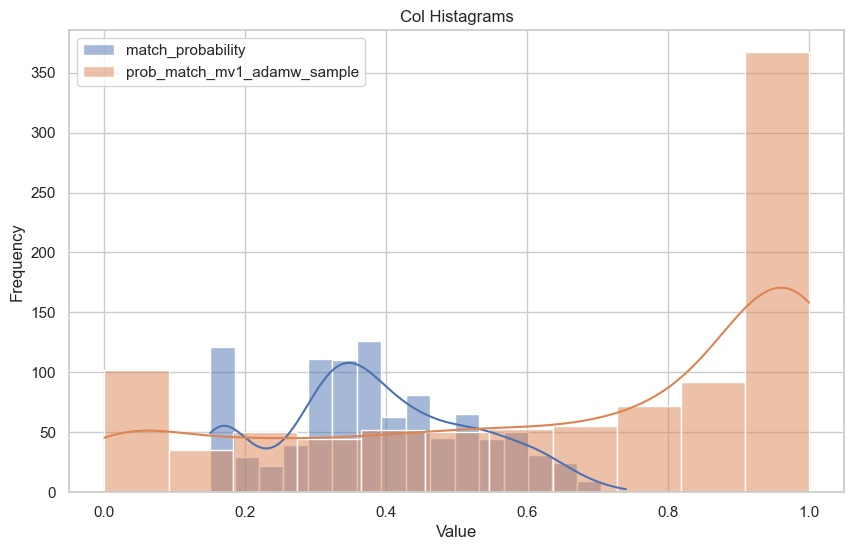

In [101]:
plot_hists_from_df(df_set2_reduced, 'match_probability',  'prob_match_mv1_adamw_sample')

In [102]:
df_set2_reduced

main_web_variety_id  candidate_web_variety_id  \
0               27400132                  56973822   
1               27400132                  56974313   
2               27400132                  56974315   
3               27400132                  56974616   
4               27400132                  56975566   
..                   ...                       ...   
967             48872161                  56974806   
968             48872161                  56974808   
969             48872161                  56975490   
970             55357037                  56974801   
971             55357037                  57198582   

                            brand_and_product  \
0                       total full lc gatos 2   
1                       total full lc gatos 2   
2                       total full lc gatos 2   
3                       total full lc gatos 2   
4                       total full lc gatos 2   
..                                        ...   
967    royal canin bulldog frances adulto 9kg   
968    royal canin bulldog frances adulto 9kg   
969    royal canin bulldog frances adulto 9kg   
970  ringo mas pro alimento seco adultos 30kg   
971  ringo mas pro alimento seco adultos 30kg   

                   brand_and_product_candidate  text_distance  ranking  \
0               total max maxcarne filhote 2kg         0.7237        2   
1              total f lc perro mediano unidad         0.7359        4   
2         total f cg cachorros suspension 15ml         0.0000        1   
3                 total f perros medianos 20ml         0.7108        3   
4                  total f perros grandes 60ml         0.7333        5   
..                                         ...            ...      ...   
967  royal canin mini adult sterilised ad 3 kl         0.0000        6   
968            royal canin feline ragdoll 2 kl         0.0000        5   
969  royal canin lata canine weight care 165gr         0.8626        4   
970        royal canin medium adult derma 3 kl         0.0000        2   
971                            ringo +pro 30kg         0.8290        1   

     image_distance  selected_as_match  match_probability  \
0              0.00                  0               0.31   
1              0.64                  0               0.28   
2              0.60                  0               0.33   
3              0.00                  0               0.31   
4              0.62                  0               0.18   
..              ...                ...                ...   
967            0.87                  0               0.45   
968            0.89                  0               0.51   
969            0.00                  0               0.57   
970            0.85                  0               0.32   
971            0.92                  1               0.33   

     prob_match_mv1_adamw_sample  
0                       0.598271  
1                       0.447819  
2                       0.001935  
3                       0.025535  
4                       0.014835  
..                           ...  
967                     0.910094  
968                     0.701002  
969                     0.601257  
970                     0.034491  
971                     0.997459  

[972 rows x 10 columns]

### df set 3

In [106]:
df_set3 = pd.read_excel('/Users/cvergarabah/Downloads/results_set-20240514020031_setid-218.xlsx', index_col=0)

In [107]:
df_set3 = df_set3[~df_set3.isnull()]
df_set3 = df_set3.drop(columns='delta_final_price')
df_set3 = df_set3.fillna('unknown')

In [108]:
df_set3['brand_and_product'] = df_set3.brand + ' ' + df_set3.product_name + ' ' + df_set3.variety_name
df_set3['brand_and_product'] = df_set3['brand_and_product'].apply(preprocess_products)

df_set3['brand_and_product_candidate'] = df_set3.brand_candidate + ' ' + df_set3.product_name_candidate + ' ' + df_set3.variety_name_candidate
df_set3['brand_and_product_candidate'] = df_set3['brand_and_product_candidate'].apply(preprocess_products)

In [113]:
df_set3_reduced = df_set3[['main_web_variety_id', 'candidate_web_variety_id','brand_and_product', 'brand_and_product_candidate',
                         'text_distance', 'ranking', 'image_distance', 'selected_as_match', 'match_probability']]

In [114]:
df_set3_reduced = df_set3_reduced.drop_duplicates()
df_set3_reduced = df_set3_reduced.reset_index(drop=True)

In [115]:
products_1 = df_set3_reduced.brand_and_product.tolist()
products_2 = df_set3_reduced.brand_and_product_candidate.tolist()

products_encoding = encode_products_bert(list(zip(products_1, products_2)),
                                                                 tokenizer=tokenizer, length=MAX_LENGTH)

with tf.device(gpus_list[0]):
    df_set3_reduced['prob_match_mv1_adamw_sample'] = model_txt_1_adamw.predict([products_encoding['input_ids'],
                                                               products_encoding['attention_mask']])

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


23/23 [==============================] - 3s 114ms/step


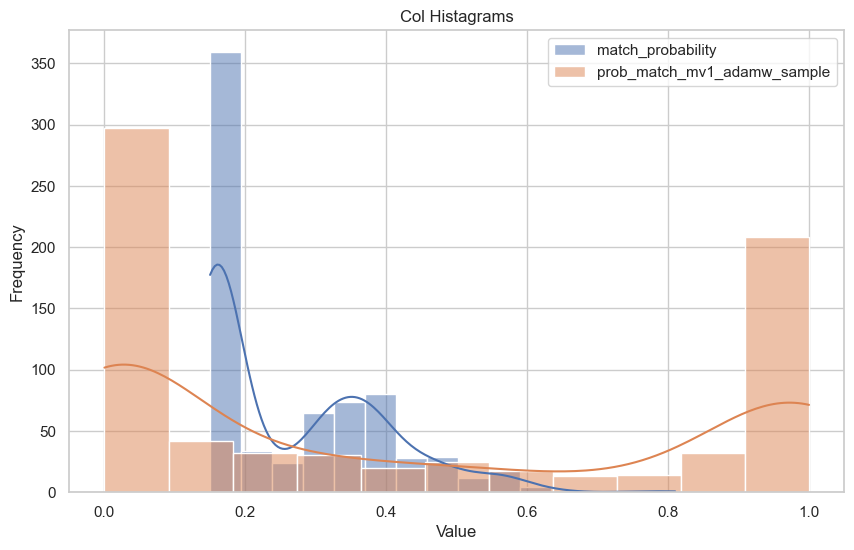

In [116]:
plot_hists_from_df(df_set3_reduced, 'match_probability', 'prob_match_mv1_adamw_sample')

In [118]:
df_set3_reduced

main_web_variety_id  candidate_web_variety_id  \
0               27401294                  61456951   
1               27402417                  23321776   
2               27402417                  32825605   
3               27402418                  23321776   
4               27402418                  32825605   
..                   ...                       ...   
725             48769210                  63284736   
726             65355811                  16553837   
727             65355811                  23321751   
728             65355811                  32825595   
729             65355811                  63284529   

                                     brand_and_product  \
0          argos guante cepillo peinar mascotas unidad   
1                      attack perros 35 hasta 60kg 6ml   
2                      attack perros 35 hasta 60kg 6ml   
3                     attack perros 5 hasta 15kg 1.5ml   
4                     attack perros 5 hasta 15kg 1.5ml   
..                                                 ...   
725           beauty pets talco hidro absorbente 100gr   
726  advocate pipeta solucion topica gatos hasta 8k...   
727  advocate pipeta solucion topica gatos hasta 8k...   
728  advocate pipeta solucion topica gatos hasta 8k...   
729  advocate pipeta solucion topica gatos hasta 8k...   

                  brand_and_product_candidate  text_distance  ranking  \
0        alana bandana panoleta perro woody m         0.0000        1   
1    advocate antiparasitario perros mas 25kg         0.7745        1   
2    advocate antiparasitario perros mas 25kg         0.7745        2   
3    advocate antiparasitario perros mas 25kg         0.7792        1   
4    advocate antiparasitario perros mas 25kg         0.7792        2   
..                                        ...            ...      ...   
725      bio pets nutraceutico skin hair 60gr         0.7839        3   
726        advocate antiparasitario gatos 8kg         0.8365        3   
727        advocate antiparasitario gatos 8kg         0.8391        1   
728        advocate antiparasitario gatos 8kg         0.8391        2   
729      advocate antiparasitario gatos 3 8kg         0.8305        4   

     image_distance  selected_as_match  match_probability  \
0              0.20                  0               0.15   
1              0.00                  0               0.15   
2              0.00                  0               0.15   
3              0.00                  0               0.15   
4              0.00                  0               0.15   
..              ...                ...                ...   
725            0.00                  0               0.15   
726            0.00                  1               0.54   
727            0.97                  0               0.54   
728            0.97                  0               0.54   
729            0.86                  0               0.41   

     prob_match_mv1_adamw_sample  
0                       0.000587  
1                       0.117632  
2                       0.117632  
3                       0.429900  
4                       0.429900  
..                           ...  
725                     0.001980  
726                     0.997993  
727                     0.997993  
728                     0.997993  
729                     0.989182  

[730 rows x 10 columns]

### df set 4

In [119]:
df_set4 = pd.read_excel('/Users/cvergarabah/Downloads/results_set-20240524041642_setid-263.xlsx', index_col=0)

In [120]:
df_set4 = df_set4[~df_set4.isnull()]
df_set4 = df_set4.drop(columns='delta_final_price')
df_set4 = df_set4.fillna('unknown')

In [121]:
df_set4['brand_and_product'] = df_set4.brand + ' ' + df_set4.product_name + ' ' + df_set4.variety_name
df_set4['brand_and_product'] = df_set4['brand_and_product'].apply(preprocess_products)

df_set4['brand_and_product_candidate'] = df_set4.brand_candidate + ' ' + df_set4.product_name_candidate + ' ' + df_set4.variety_name_candidate
df_set4['brand_and_product_candidate'] = df_set4['brand_and_product_candidate'].apply(preprocess_products)

In [122]:
df_set4_reduced = df_set4[['main_web_variety_id', 'candidate_web_variety_id','brand_and_product', 'brand_and_product_candidate',
                         'text_distance', 'ranking', 'image_distance', 'selected_as_match', 'match_probability']]
df_set4_reduced = df_set4_reduced.drop_duplicates()
df_set4_reduced = df_set4_reduced.reset_index(drop=True)

In [123]:
products_1 = df_set4_reduced.brand_and_product.tolist()
products_2 = df_set4_reduced.brand_and_product_candidate.tolist()

products_encoding = encode_products_bert(list(zip(products_1, products_2)),
                                                                 tokenizer=tokenizer, length=MAX_LENGTH)

with tf.device(gpus_list[0]):
    df_set4_reduced['prob_match_mv1_adamw_sample'] = model_txt_1_adamw.predict([products_encoding['input_ids'],
                                                               products_encoding['attention_mask']])

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

21/21 [==============================] - 6s 280ms/step


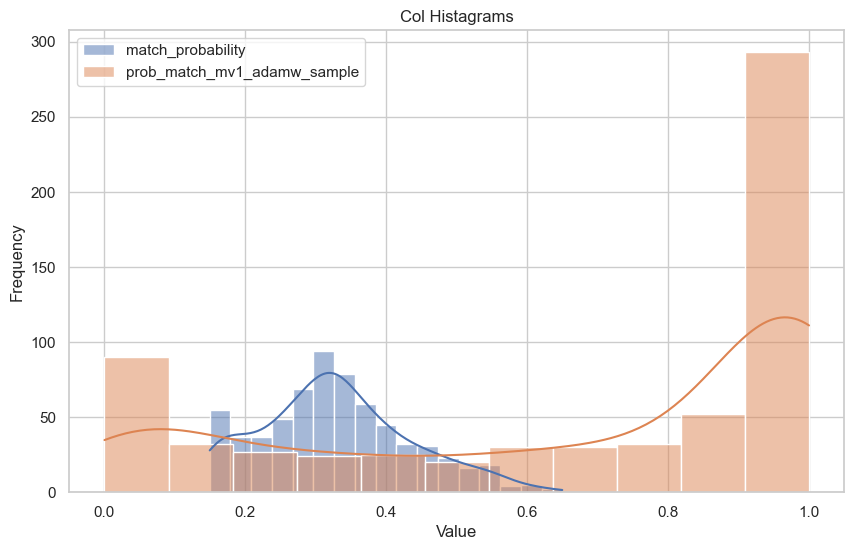

In [125]:
plot_hists_from_df(df_set4_reduced, 'match_probability', 'prob_match_mv1_adamw_sample')

In [124]:
df_set4_reduced

main_web_variety_id  candidate_web_variety_id  \
0               56203527                  51901905   
1               56203528                  51901903   
2               56203528                  51901905   
3               56203535                  51901821   
4               56203536                  51901821   
..                   ...                       ...   
650             56203821                  51912105   
651             56203821                  62201062   
652             56203821                  62225164   
653             56203821                  62225165   
654             56203821                  62225166   

                                brand_and_product  \
0         canbo adulto cordero razas pequenas 3kg   
1         canbo adulto cordero razas pequenas 7kg   
2         canbo adulto cordero razas pequenas 7kg   
3           canbo enlatado optima digestion 330gr   
4                 canbo enlatado energetico 330gr   
..                                            ...   
650  pro plan proplan adulto salmon arroz 368.5gr   
651  pro plan proplan adulto salmon arroz 368.5gr   
652  pro plan proplan adulto salmon arroz 368.5gr   
653  pro plan proplan adulto salmon arroz 368.5gr   
654  pro plan proplan adulto salmon arroz 368.5gr   

                      brand_and_product_candidate  text_distance  ranking  \
0             carnilove duck pheasant 400gr 11311         0.0000        1   
1             carnilove salmon turkey 400gr 11312         0.0000        2   
2             carnilove duck pheasant 400gr 11311         0.0000        1   
3                canbo super prem biscuit x 200gr         0.7604        1   
4                canbo super prem biscuit x 200gr         0.7461        1   
..                                            ...            ...      ...   
650  proplan cat adulto pollo arroz 85gr 12480086         0.8436        2   
651          proplan adult cordero 7.5kg 12532194         0.7714        6   
652                     proplan puppy cordero 3kg         0.7679        3   
653                    proplan puppy cordero15 kg         0.7632        5   
654            proplan adult cordero 3kg 12532121         0.8175        4   

    image_distance  selected_as_match  match_probability  \
0             0.59                  0               0.15   
1             0.57                  0               0.15   
2             0.59                  0               0.15   
3              0.0                  0               0.33   
4              0.0                  0               0.31   
..             ...                ...                ...   
650           0.67                  0               0.38   
651            0.0                  0               0.32   
652            0.0                  0               0.35   
653            0.0                  0               0.35   
654            0.0                  0               0.35   

     prob_match_mv1_adamw_sample  
0                       0.001264  
1                       0.001849  
2                       0.001707  
3                       0.023208  
4                       0.024814  
..                           ...  
650                     0.028748  
651                     0.023028  
652                     0.003842  
653                     0.002765  
654                     0.005253  

[655 rows x 10 columns]